In [1]:
import glob
import os
from collections import Counter
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

from sklearn.metrics import pairwise_distances
import lxml.etree
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from IPython.display import display

In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

## Loading and preprocessing

In [2]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,date,provenance,date_range,genre,subgenre,exclude
266,van_ses_vaerwen,Van ses vaerwen ende twaelf outheyden,NaN,1410.0,cdrom-mnl,1400-1420,Epiek,Didactiek,NaN
63,florigout_fragm_l,Florigout,NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Ridder,NaN
111,loyhier_en_malaert_fragm_a,Loyhier en Malaert,NaN,1375.0,cdrom-mnl,1350-1400,Epiek,Karel,NaN
86,historie_van_gaver_capeel,Historie van Gaver Capeel,NaN,1510.0,cdrom-mnl,1500-1520,Epiek,Ridder,NaN
168,renout_van_montalbaen_fragm_be,Renout van Montalbaen,NaN,1350.0,cdrom-mnl,1340-1360,Epiek,Karel,NaN
211,spiegel_der_sonden,Spiegel der sonden,NaN,1450.0,cdrom-mnl,1440-1460,Epiek,Didactiek,NaN
210,spiegel_der_jongers,Spiegel der jongers,Lambertus Goetman,1515.0,cdrom-mnl,1510-1520,Epiek,Didactiek,NaN
123,madelgijs_fragm_p,Madelgijs,NaN,1387.5,cdrom-mnl,1375-1400,Epiek,Karel,NaN
166,reinaerts_historie,Reinaerts historie,NaN,1470.0,cdrom-mnl,1460-1480,Epiek,Dier,NaN
239,suverlijc_boecxken,Suverlijc boecxken,NaN,1508.0,cdrom-mnl,1508-1508,Lyriek,NaN,NaN


In [61]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size - 1)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                yield 'overlap'
            else:
                yield list(its.keys())[0]

In [4]:
def parse_xml(fn, rm_interpol=False):
    try:
        tree = lxml.etree.parse(fn)
    except OSError:
        print(f'- Could not load {fn}')
        return None
        
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
        
    for line_node in tree.iterfind('//l'):
        try:
            intertext_id = line_node.attrib['intertext']
        except KeyError:
            intertext_id = None
        
        tokens_ = line_node.attrib['tokens'].split()
        lemmas_ = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        lemmas_.append('n(prop)')
                    else:
                        lemmas_.append(l)
    
        yield tokens_, lemmas_, intertext_id

In [66]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        for tok, lem, intertext_id in parse_xml(f'../data/xml/{id_}.xml'):
            work_tokens.append(tok)
            work_lemmas.append(lem)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

 71%|███████   | 146/205 [00:23<00:09,  6.34it/s]


KeyboardInterrupt: 

In [6]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df = df[df['intertext'] != 'overlap']
df.head()
#df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext
0,AB recht ende averecht,Aensiet dese vrouwen hoe si gaen / Besiet hoe haer tuten staen,aanzien deze vrouw hoe zij gaan / bezien hoe zij de staan,None
1,AB recht ende averecht,Besiet hoe haer tuten staen / Claer dat si hen blanketten,bezien hoe zij de staan / klaar dat zij zij n(prop),None
2,AB recht ende averecht,Claer dat si hen blanketten / Die cleeder soe lanc dat si hen letten,klaar dat zij zij n(prop) / de kleed zo lang dat zij zij letten,None
3,AB recht ende averecht,Die cleeder soe lanc dat si hen letten / Ende sleypen hen nae al op die eerde,de kleed zo lang dat zij zij letten / en slapen zij na al op de aarde,None
4,AB recht ende averecht,Ende sleypen hen nae al op die eerde / Fi diere vuylder hoverde,en slapen zij na al op de aarde / fi duur vouwer hovaardij,None


In [7]:
vec = TfidfVectorizer(max_features=10000, min_df=2, token_pattern=r"(?u)\b\w+\b")
X = vec.fit_transform(df['lemmas'])
X.shape

(924694, 10000)

In [8]:
def add_rhyme_column(df):
    rhyme_words = []
    for lemmas in df['lemmas']:
        rhymes = []
        for verse in lemmas.split(' / '):
            rhymes.append(verse.strip().split()[-1])
        rhyme_words.append(' '.join(rhymes))
    df['rhyme'] = rhyme_words
    return df

In [9]:
df = add_rhyme_column(df)
df.head()
#df[(df['title'] == 'Karel ende Elegast') & (~df['intertext'].isna())]

,title,tokens,lemmas,intertext,rhyme
0,AB recht ende averecht,Aensiet dese vrouwen hoe si gaen / Besiet hoe haer tuten staen,aanzien deze vrouw hoe zij gaan / bezien hoe zij de staan,None,gaan staan
1,AB recht ende averecht,Besiet hoe haer tuten staen / Claer dat si hen blanketten,bezien hoe zij de staan / klaar dat zij zij n(prop),None,staan n(prop)
2,AB recht ende averecht,Claer dat si hen blanketten / Die cleeder soe lanc dat si hen letten,klaar dat zij zij n(prop) / de kleed zo lang dat zij zij letten,None,n(prop) letten
3,AB recht ende averecht,Die cleeder soe lanc dat si hen letten / Ende sleypen hen nae al op die eerde,de kleed zo lang dat zij zij letten / en slapen zij na al op de aarde,None,letten aarde
4,AB recht ende averecht,Ende sleypen hen nae al op die eerde / Fi diere vuylder hoverde,en slapen zij na al op de aarde / fi duur vouwer hovaardij,None,aarde hovaardij


## Nearest neighbors

In [10]:
def nearest_verses(title1, title2, base_df, vectorizer, prop_filt=2, rhyme_weight=.25):
    A = base_df[base_df['title'] == title1]
    B = base_df[base_df['title'] == title2]
    
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    
    nearest = []
    for i, ax in enumerate(AX):
        distances = pairwise_distances(ax, BX, metric='cosine').flatten()
        top_i = distances.argsort()[0]
        nearest.append((A.iloc[i]['tokens'], B.iloc[top_i]['tokens'],
                        A.iloc[i]['lemmas'], B.iloc[top_i]['lemmas'],
                        A.iloc[i]['title'], B.iloc[top_i]['title'],
                        A.iloc[i]['intertext'], B.iloc[top_i]['intertext'],
                        distances[top_i]))

    nearest = pd.DataFrame(nearest,
                           columns=['tokens1', 'tokens2', 'lemmas1', 'lemmas2',
                                    'title1', 'title2', 'intertext1', 'intertext2',
                                    'distance'])

    nearest = nearest[nearest['title1'] != nearest['title2']]
    nearest = nearest[
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) & \
                      (nearest['lemmas1'].str.count('n\(prop\)') < prop_filt) 
                     ]
    return nearest

In [12]:
nearest_df = nearest_verses('Moriaen', 'Karel ende Elegast',
                            base_df=df, vectorizer=vec, prop_filt=2)
#nearest_df = nearest_verses('Limborch', 'Roman der Lorreinen',
#nearest_df = nearest_verses('Limborch', 'Ferguut',

nearest_df = nearest_df.sort_values(by='distance')
nearest_df.head(50)

,tokens1,tokens2,lemmas1,lemmas2,title1,title2,intertext1,intertext2,distance
163,Nu es leden die derde dach / Dat ic voer om min bejach,Dies is leden die derde dach / Dat ic voer om mijn beiach,nu zijn lijden de derde dag / dat ik varen om mijn bejag,die zijn lijden de derde dag / dat ik varen om mijn bejag,Moriaen,Karel ende Elegast,mor-ele-44,mor-ele-44,0.032439
2909,Ende segt mi ende maect mi vroet / Wat noetsaken dat u doet,In dien dat ghi mi maket vroet / Wat nootsaken dat v doet,en zeggen ik en maken ik vroed / wat noodzaak dat gij doen,in die dat gij ik maken vroed / wat noodzaak dat uw doen,Moriaen,Karel ende Elegast,mor-ele-31,mor-ele-31,0.113170
193,Want ic come u te genaden / Van allen minen mesdaden,Ic come v heden te ghenaden / Van allen minen misdaden,want ik komen gij te genade / van al mijn misdaad,ik komen gij heden te genade / van al mijn misdaad,Moriaen,Karel ende Elegast,mor-ele-72,mor-ele-72,0.119944
1288,Men doet mi lachter onverdient / Quame enech Gods vrient,Dadi mi lachter onuerdient / Ghi hadt verloren menigen vrient,men doen ik lachter onverdiend / komen enig god vriend,doen ik lachter onverdiend / gij hebben verliezen menig vriend,Moriaen,Karel ende Elegast,None,None,0.180554
1839,Die grote ondaet ende die mort / Hi sprac te sinen lieden vort,Dat ghi segt ende brenct voort / Die ondaet ende die moort,de groot ondaad en de moord / hij spreken te zijn lieden voort,dat gij zeggen en brengen voort / de ondaad en de moord,Moriaen,Karel ende Elegast,mor-ele-70,mor-ele-70,0.184400
447,Dan mi een ridder dwingen soude / Van dies ic doen nine woude,Dat mi een man dwinghen soude / Van dinghen die ic niet en woude,dan ik een ridder dwingen zullen / van die ik doen ne niet willen,dat ik een man dwingen zullen / van ding die ik niet ne willen,Moriaen,Karel ende Elegast,mor-ele-22,mor-ele-22,0.195150
893,U ne gesciets niet te wors / Her Walewein sat doe op sijn ors,Al souts mi sijn te wors / Nv sit weder op v ors,gij ne geschieden niet te waars / heer n(prop) zitten toen op zijn hors,al zullen ik zijn te waars / nu zitten weer op uw hors,Moriaen,Karel ende Elegast,mor-ele-78,mor-ele-78,0.204879
877,Maer wistic uwer beider name / Ende u wille ware ende bequame,Ick sel v segghen minen name / Ist v wille ende bequame,maar ik weten uw beide naam / en uw wil zijn en bekwaam,ik zullen gij zeggen mijn naam / zijn het uw wil en bekwaam,Moriaen,Karel ende Elegast,mor-ele-38,mor-ele-38,0.205619
2949,Si hadden daer soe grote macht / Ende vingen Arture met harre cracht,Eggeric was van groter macht / Ende alle die hadden cracht,zij hebben daar zo groot macht / en vangen n(prop) met haar kracht,n(prop) zijn van groot macht / en al die hebben kracht,Moriaen,Karel ende Elegast,None,None,0.229390
3763,Doe pensdi in sinen moet / Op dattie trappen waren so goet,Pensde hi in sinen moet / Dat ick leue waer toe ist goet,toen hij peinzen in zijn moed / op dat de n(prop) zijn zo goed,peinzen hij in zijn moed / dat ik leven zijn toe zijn het goed,Moriaen,Karel ende Elegast,None,None,0.233516


In [13]:
meta = pd.read_excel('../data/intertexts.xlsx')
meta

,ID,source,src-passage,target,trg-passage,verse-length,biblio,remarks,Unnamed: 8
0,mor-ele-1,Moriaen,Dat magic v nv tellen,Karel ende Elegast,Mach ic v tellen,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
1,mor-ele-2,Moriaen,hilt hof Om te merre sinen lof.,Karel ende Elegast,houden hof Omme te meerne sinen lof:,2,"Heeroma 1973a, Moriaen (I)",NaN,NaN
2,mor-ele-3,Moriaen,Hastelike ende nine spard.,Karel ende Elegast,Haestelic ende niet en spaert:,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
3,mor-ele-4,Moriaen,Nv nes niweren in ertrike.,Karel ende Elegast,En es man in aertrijcke:,1,"Heeroma 1973a, Moriaen (I)",NaN,NaN
4,mor-ele-5,Moriaen,sine macht (es) so groet Ic waen men nigeren sine genoet Ne soude vinden.,Karel ende Elegast,Mijns selfs lant es soe groot Men vint nyewers sijns ghenoot:,3,"Heeroma 1973a, Moriaen (I)",NaN,NaN
...,...,...,...,...,...,...,...,...,...
224,mor-ele-40,Lantsloot van der Haghedochte,Ende droegen des ouer een:,Moriaen,Ende drogen des daer ouer een.,1,NaN,Nestedness!,NaN
225,mor-ele-61,Lantsloot van der Haghedochte,Dien hi harde lange voer Ende vernam van niemene boer:,Moriaen,Daer men met scepen ouer voer Ende daer verlosic al dat boer.,2,NaN,NaN,NaN
226,lan-ele-74,Lantsloot van der Haghedochte,Ende sijn ors toe gemake gedaen:,Moriaen,Sijn ors was te gemake gedaen.,1,NaN,NaN,NaN
227,lan-ele-75,Lantsloot van der Haghedochte,Doe die dienst was gedaen:,Moriaen,Doe die dinst was gedaen.,1,NaN,NaN,NaN


## Precision-recall paradigm

In [14]:
def precision_recall(df, meta, vec, rhyme_weight=.25):
    titles = set(list(meta['source']) + list(meta['target']))
    relevances, distances = [], []

    for t1, t2 in product(titles, titles):
        if t1 == t2:
            continue

        m = meta[meta['verse-length'] >= 2]
        m = m[(m['source'] == t1) | (m['source'] == t2)]
        m = m[(m['target'] == t1) | (m['target'] == t2)]

        if not len(m):
            continue

        A = df[(~df['intertext'].isna()) & (df['title'] == t1)]
        B = df[df['title'] == t2]

        AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
        BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

        all_distances = pairwise_distances(AX, BX, metric='cosine')

        for a_idx, (_, a) in enumerate(A.iterrows()):
            distances.extend(all_distances[a_idx])
            relevances.extend((B['intertext'] == a['intertext']).astype(int))
    
    return relevances, distances

In [15]:
relevances, distances = precision_recall(df, meta, vec, rhyme_weight=0)

Use complement of the cosine distance as a pseudo-probability:

In [16]:
distances = 1 - np.array(distances)

max(f1)=0.3538 @ theta=0.5008


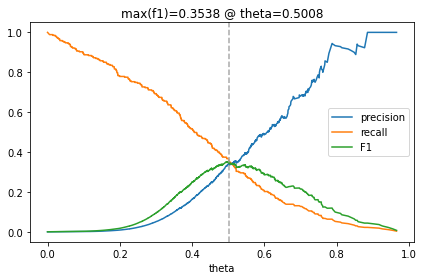

In [17]:
precisions, recalls, thresholds = precision_recall_curve(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout()

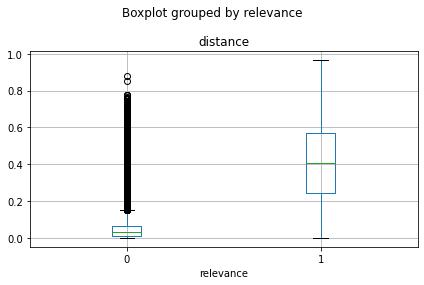

In [18]:
res_df = pd.DataFrame(zip(distances, relevances), columns=('distance', 'relevance'))
res_df.boxplot('distance', 'relevance')
plt.tight_layout();

#### Calibrate parameters

Like rhyme weight:

In [19]:
scores = []

# also negative weight for demonstration purposes:
rhyme_weights = tuple(np.linspace(-.3, 2.0, 50))

from sklearn.metrics import roc_auc_score

for rhyme_weight in tqdm(rhyme_weights):
    relevances, distances = precision_recall(df, meta, vec, rhyme_weight=rhyme_weight)
    distances = 1 - np.array(distances)
    auc = roc_auc_score(relevances, distances)
    av_prec = average_precision_score(relevances, distances)
    scores.append((rhyme_weight, auc, av_prec))

100%|██████████| 50/50 [03:58<00:00,  4.77s/it]


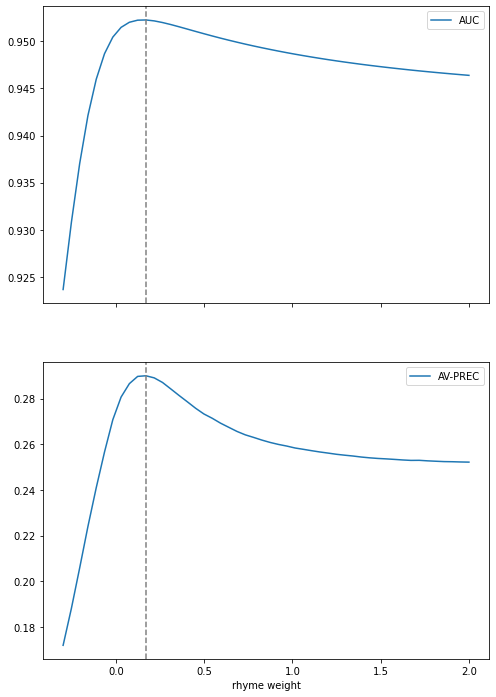

In [20]:
scores = pd.DataFrame(scores, columns=('rhyme weight', 'AUC', 'AV-PREC'))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 12))
scores.plot('rhyme weight', 'AUC', ax=ax1)
ax1.axvline(scores.iloc[scores['AUC'].idxmax()]['rhyme weight'], ls='--', c='grey')
scores.plot('rhyme weight', 'AV-PREC', ax=ax2)
ax2.axvline(scores.iloc[scores['AV-PREC'].idxmax()]['rhyme weight'], ls='--', c='grey');

In [21]:
optim_rw = scores.iloc[scores['AUC'].idxmax()]['rhyme weight']
optim_rw

0.1693877551020408

Vocabulary size?

In [22]:
vec = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", min_df=2, max_features=None)
vec.fit(df['lemmas'])
print(len(vec.get_feature_names()))

40568


Vocabulary size for TF and TF-IDF:

In [23]:
scores = []

vocab_sizes = list(range(500, 20000, 500))
parametrizations = {
                    'TF-IDF': {'min_df':2},
                    'TF': {'use_idf':False, 'min_df':2},
                    }

for vocab_size in tqdm(vocab_sizes):
    for param_name, param in parametrizations.items():
        param['max_features'] = vocab_size
        vec = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", **param)
        vec.fit(df['lemmas'])
        relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
        distances = 1 - np.array(distances)
        auc = roc_auc_score(relevances, distances)
        av_prec = average_precision_score(relevances, distances)
        scores.append((param_name, vocab_size, auc, av_prec))
scores = pd.DataFrame(scores, columns=('param', 'vocab_size', 'AUC', 'AV-PREC'))

100%|██████████| 39/39 [16:30<00:00, 25.40s/it]


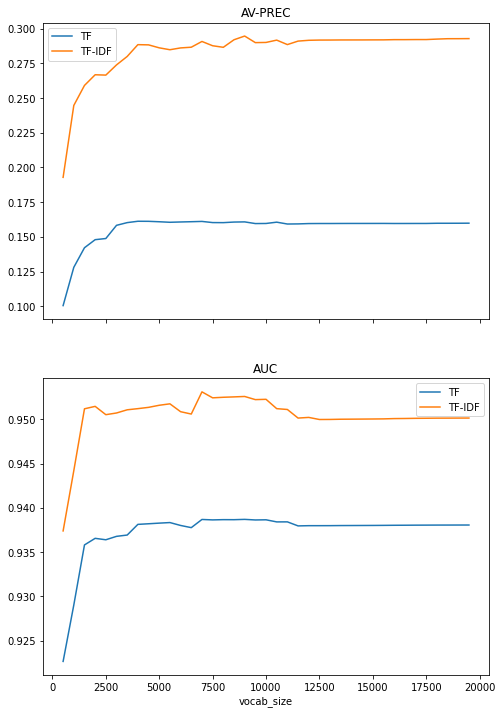

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 12))

for p, gr in scores.groupby('param'):
    gr.plot('vocab_size', 'AV-PREC', label=p, ax=ax1)
ax1.set_title('AV-PREC')
    
for p, gr in scores.groupby('param'):
    gr.plot('vocab_size', 'AUC', label=p, ax=ax2)
ax2.set_title('AUC');

In [25]:
scores['comb'] = scores['AUC'] * scores['AV-PREC']
optim_vs = scores.iloc[scores['AUC'].idxmax()]
display(optim_vs)
optim_vs = optim_vs['vocab_size']
#optim_vs

param         TF-IDF  
vocab_size    7000    
AUC           0.953101
AV-PREC       0.290712
comb          0.277078
Name: 26, dtype: object

## Final threshold

max(f1)=0.3587 @ theta=0.5624


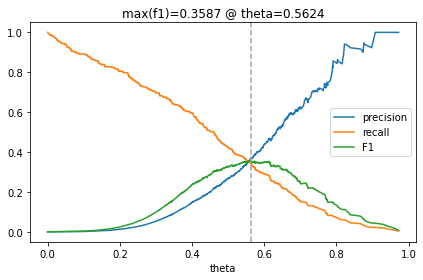

In [26]:
vec = TfidfVectorizer(max_features=40000, min_df=2,
                      token_pattern=r"(?u)\b\w+\b")
vec.fit(df['lemmas'])
relevances, distances = precision_recall(df, meta, vec, rhyme_weight=optim_rw)
distances = 1 - np.array(distances)
precisions, recalls, thresholds = precision_recall_curve(relevances, distances)
f1s = (2 * precisions * recalls) / (precisions + recalls)

max_f1_idx = np.array(f1s).argmax()
max_f1 = f1s[max_f1_idx]
max_f1_th = thresholds[max_f1_idx]
print(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')

plt.plot(thresholds, precisions[:-1], label='precision')
plt.plot(thresholds, recalls[:-1], label='recall')
plt.plot(thresholds, f1s[:-1], label='F1')
plt.axvline(max_f1_th, ls='--', c='darkgrey')
plt.gca().set_xlabel('theta')
plt.gca().legend()
plt.title(f'max(f1)={round(max_f1, 4)} @ theta={round(max_f1_th, 4)}')
plt.tight_layout()

## Case studies

#### Well-known cases of intertextual borrowings at the MACRO-level

In [27]:
def distance_nn(title1, title2, rhyme_weight=.25, batch_size=5000):
    
    def batch(iterable, n=1):
        l = iterable.shape[0]
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]
    
    A = df[df['title'] == title1]
    B = df[df['title'] == title2]

    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

    all_distances = []

    for ax in batch(AX, batch_size):
         all_distances.extend(pairwise_distances(ax, BX, metric='cosine').min(axis=1))
    
    return pd.Series(all_distances)

def plot_min_distance_nn(t1, t2, min_dists, threshold, rolling_size=1000):
    mu = min_dists.rolling(rolling_size).mean()
    fig, ax = plt.subplots()
    mu.plot(ax=ax)
    ax.axhline(threshold, ls='--', c='grey')
    ax.set_ylim(0, 1)
    ax.set_xlabel(t1)
    ax.set_ylabel('Distance to NN in ' + t2)
    return ax

In [28]:
rolling_size, threshold = 1000, 1 - max_f1_th
print(threshold)

0.43762670553485417


In [29]:
def get_interpolations(title):
    fn = meta_df[meta_df['title'] == title]['id'].iloc[0]
    tree = lxml.etree.parse(f'../data/xml/{fn}.xml').getroot()
    interpol_idxs, interpol_names, line_cnt = [], [], 0
    for element in tree:
        line_cnt += 1
        if element.tag == 'interpolation':
            idxs, length = line_cnt, len(element.findall('l'))
            interpol_idxs.append([line_cnt, line_cnt + length])
            line_cnt += length
            interpol_names.append(element.attrib['reason'])
            
    return interpol_idxs, interpol_names

Heelu in de Vijfde Partie:

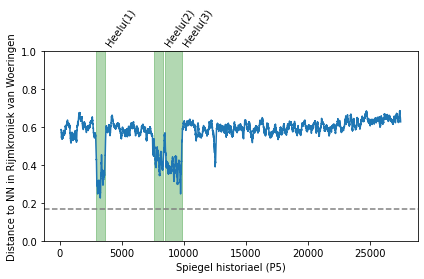

In [30]:
t1, t2 = 'Spiegel historiael (P5)', 'Rijmkroniek van Woeringen'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_rw, rolling_size=100)
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if n.startswith('Heelu'):
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

Maerlant in de Brabantse yeesten:

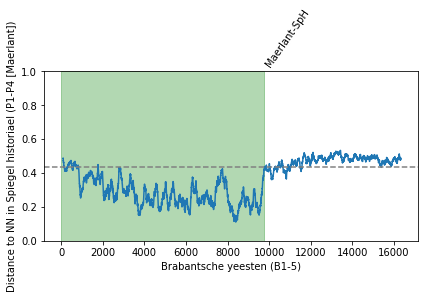

In [31]:
t1, t2 = 'Brabantsche yeesten (B1-5)', 'Spiegel historiael (P1-P4 [Maerlant])'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
    plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

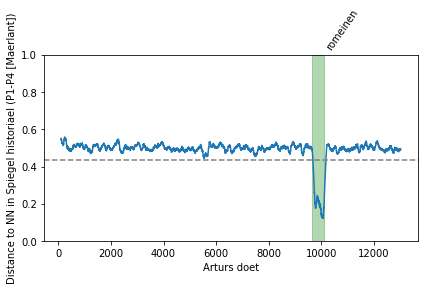

In [32]:
t1, t2 = 'Arturs doet', 'Spiegel historiael (P1-P4 [Maerlant])'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'gebed' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()

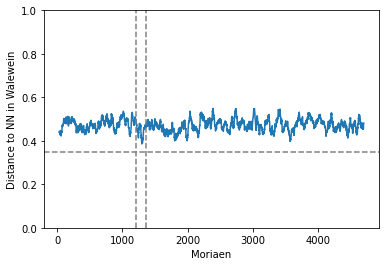

In [15]:
t1, t2 = 'Moriaen', 'Walewein'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=35)
ax.axvline(1215, c='grey', ls='--')
ax.axvline(1365, c='grey', ls='--');

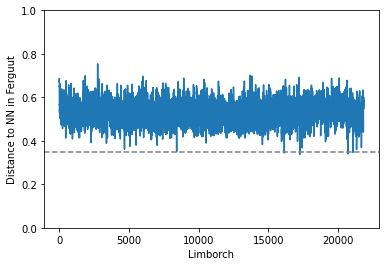

In [18]:
t1, t2 = 'Limborch', 'Ferguut'
min_dists = distance_nn(t1, t2, rhyme_weight=optim_rw)
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=threshold, rolling_size=10)

#### Large-scale detection

In [31]:
#chiv_titles = meta_df[meta_df['subgenre'].isin(('Arthur', 'Ridder', 'Karel', 'Kruisvaart', 'Dier'))]['title'].unique()
chiv_titles = meta_df[meta_df['genre'] == 'Epiek']['title'].unique()
chiv_titles

array(['Alexanders geesten', 'Alexiuslegende', 'Anatomie van de mens',
       'Arturs doet', 'Aubri de Borgengoen', 'Barlaam en Josaphat',
       'Beatrijs', 'Bediedenisse van der missen',
       'Beerte metten breden voeten', 'Beginsel der oorlogen van Luyck',
       'Boec Exemplaer', 'Boec van den houte', 'Boec vander wraken',
       'Boeve van Hamtone', 'Borchgrave van Couchi',
       'Borchgravinne van Vergi (1)', 'Borchgravinne van Vergi (2)',
       'Boudewijn van Seborch', 'Brabantsche yeesten (B1-5)',
       'Brabantsche yeesten (B6)', 'Brabantsche yeesten (B7)',
       'Nevelingenlied', "Chanson d'Aspremont", 'Collectief lunarium I',
       'Collectief lunarium III', 'Commentaar op het Hooglied',
       'Collectief lunarium II', 'Cyromanchie van den pape van den Hamme',
       'Der leken spieghel', 'Der mannen ende vrouwen heimelijcheit',
       'Der minnen loep', 'Der naturen bloeme',
       'Der vrouwen heimelijcheit', 'Der ystorien bloeme',
       'Dietsche doctrinale', 'Di

In [32]:
#results = []
#for t1, t2 in tqdm(product(['Arturs doet'], chiv_titles)):
#for t1, t2 in tqdm(product(['Karel ende Elegast'], chiv_titles)):
#for t1, t2 in tqdm(list(product(chiv_titles, chiv_titles))):
#    if t1 == t2:
#        continue
#    results.append((t1, t2, distance_nn(t1, t2, batch_size=10000)))

In [33]:
#results = pd.DataFrame(results, columns=('t1', 't2', 'nn'))
#results

In [34]:
#rolling_size = 100
#for _, r in results.iterrows():
#    if np.any(r['nn'].rolling(rolling_size).mean() < threshold):
#        plot_min_distance_nn(r['t1'], r['t2'], r['nn'],
#threshold=threshold, rolling_size=rolling_size);

### Single-text

In [39]:
#for t in chiv_titles:
#    d = results[results['t1'] == t]
#    D = np.array([_ for _ in d['nn'].values])
#    D = pd.DataFrame(D)
#    D.mean().rolling(50).mean().plot(title=t)
#    plt.ylim(0, 1)
#    plt.show()

## Meso-scale interetextuality

Case studies in sutbler intertextual connections as the MESO-scale. Fro this, we set the rhyme weight to 0.
- Prieel-scene Limborch vs Historie van Troyen
- River scene: Walewein vs Moriaen
- Hart-scene Ferguut vs Limborch

In [140]:
def load_meso_text(fn, title, group_size=None):
    work_tokens, work_lemmas = [], []
    for tok, lem, intertext_id in parse_xml(fn):
        work_tokens.append(tok)
        work_lemmas.append(lem)

    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]
    
    if not group_size:
        group_size = len(verse_tokens)

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=group_size))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=group_size))
    
    meso = pd.DataFrame(zip([title] * len(verse_group_tokens), verse_group_tokens, verse_group_lemmas),
                      columns=('title', 'tokens', 'lemmas'))
    meso = add_rhyme_column(meso)
    
    return group_size, meso

def top_meso(A, B, rhyme_weight, k=3):
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    D = pd.Series(pairwise_distances(BX, AX, metric='cosine').min(axis=1))
    top_idxs = D.argsort()[:k]
    top_hits = B.iloc[top_idxs]
    return top_hits

In [141]:
group_size, prieel = load_meso_text(fn='../data/meso/prieel.xml', title='Prieel')
_, HvT = load_meso_text(fn='../data/xml/roman_van_limborch.xml', title='Limborch',
                        group_size=group_size)
top_meso(prieel, HvT, rhyme_weight=0, k=20)

,title,tokens,lemmas,rhyme
7363,Limborch,Ende voeren te Grieken waert / Nu latic staen van hare vaert / Ende seggu van Echites voert / Dien de minne sere cort / Ende reet berch ende dal / Gode hi hem altoes beval / Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware,en varen te n(prop) waart / nu ik laten staan van haar vaart / en zeggen du van ethites voorts / die de minne zeer kort / en rijden berg en dal / n(prop) hij hij altoos bevelen / zo lang rijden de ridder koen / dat hij een morgen voor noen / komen in een schoon vergier / in midden staan een eglendier / boven een schoon fontein / ik zullen al de schoonheid rein / prijzen het zijn ik te zwaar / de fontein zijn ook zo klaar / dat wonder te zeggen zijn,waart vaart voorts kort dal bevelen koen noen vergier eglendier fontein rein zwaar klaar zijn
7369,Limborch,Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware / Die ridder peinsde eer ic vort vare / Willic mi hier een luttel rusten / Het mochts elken mensce lusten / Te rustene in alsoe sconer stede / Hi beete neder ende dede / Siin ors peistren gaen int gras,zo lang rijden de ridder koen / dat hij een morgen voor noen / komen in een schoon vergier / in midden staan een eglendier / boven een schoon fontein / ik zullen al de schoonheid rein / prijzen het zijn ik te zwaar / de fontein zijn ook zo klaar / dat wonder te zeggen zijn / de ridder peinzen eer ik voort varen / ik willen ik hier een luttel rusten / het mogen elk mens lusten / te rusten in alzo schoon stad / hij beten neder en doen / zijn hors peister gaan het in gras,koen noen vergier eglendier fontein rein zwaar klaar zijn varen rusten lusten stad doen gras
7364,Limborch,Nu latic staen van hare vaert / Ende seggu van Echites voert / Dien de minne sere cort / Ende reet berch ende dal / Gode hi hem altoes beval / Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware / Die ridder peinsde eer ic vort vare,nu ik laten staan van haar vaart / en zeggen du van ethites voorts / die de minne zeer kort / en rijden berg en dal / n(prop) hij hij altoos bevelen / zo lang rijden de ridder koen / dat hij een morgen voor noen / komen in een schoon vergier / in midden staan een eglendier / boven een schoon fontein / ik zullen al de schoonheid rein / prijzen het zijn ik te zwaar / de fontein zijn ook zo klaar / dat wonder te zeggen zijn / de ridder peinzen eer ik voort varen,vaart voorts kort dal bevelen koen noen vergier eglendier fontein rein zwaar klaar zijn varen
7370,Limborch,Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware / Die ridder peinsde eer ic vort vare / Willic mi hier een luttel rusten / Het mochts elken mensce lusten / Te rustene in alsoe sconer stede / Hi beete neder ende dede / Siin ors peistren gaen int gras / Hi ghinc liggen als ict las,dat hij een morgen voor noen / komen in een schoon vergier / in midden staan een eglendier / boven een schoon fontein / ik zullen al de schoonheid rein / prijzen het zijn ik te zwaar / de fontein zijn ook zo klaar / dat wonder te zeggen zijn / de ridder peinzen eer ik voort varen / ik willen ik hier een luttel rusten / het mogen elk mens lusten / te rusten in alzo schoon stad / hij be

Walewein-passage in Moriaen: vs. 3676 (*Mettien quam hi up ene riviere*) t.e.m. vs. 3856 (*Ende hare twier scachte braken*)

In [142]:
group_size, rivier = load_meso_text(fn='../data/meso/rivier.xml', title='Rivier')
_, Mor = load_meso_text(fn='../data/xml/roman_van_moriaen.xml', title='Moriaen',
                        group_size=group_size)
display(rivier)
top_meso(rivier, Mor, rhyme_weight=0, k=1)

title  \
0  Rivier   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

title  \
1221  Moriaen   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Naar [Knuttel](https://www.dbnl.org/tekst/_tij003194401_01/_tij003194401_01_0003.php).
Hart-passage (niet duidelijk afgegrensd door eerdere onderzoekers) uit Ferguut: vs. 1365 (*Arger ben ic dan een dief*) - vs. 1453 (*Algader hoet met haer stoet ende ware*)

In [143]:
group_size, hart = load_meso_text(fn='../data/meso/hart.xml', title='Hart')
_, Lim = load_meso_text(fn='../data/xml/roman_van_limborch.xml', title='Limborch',
                        group_size=group_size)
display(hart)
top_meso(hart, Lim, rhyme_weight=0, k=10)

,title,tokens,lemmas,rhyme
0,Hart,Arger ben ic dan een dief / Dat ic den genen wille hebben lief / Die ic noit en sach meer dan heden / Noch en sprac in eneger steden / Morgen so sal hi orlof / Betide nemen ende ltrumen thofgt / Dan sal hi nemmer van mi weten / Saen sal hi mijns vergeten / In weet hoes hem gedinken mochte / Dade hi altenen in sijn gedochte / Daer hi quame alle ioncfrouwen / Het ware heme quaet te minen trouwen / Hi vaert tielec wech metten dage / Hoe sal hi geweten mine clage / Hoe wel dat icken minnen mach / Hi sal mi geuen den doet slach / Wisti dat ic in selken vare / In allen stonden dore hem ware / Hine dade nemmer die dorperheltidegt / Dat hi mi sine minne ontseide / Secgict hem niet hine weet nommer / Wi seggict hem ic segge mi commer / Waer soudic nemen die gedachte / Ic soude onneren mijn geslachte / Ic lage mi lieuer jndie doet kiste / Dan hijt van minen monde wiste / Wat doe ic dan ic sal wech vlien / Om enen andren salic spien / In willen sien in al mijn leuen / Mijn vader wille mi emmer geuen / Enen hogen prinche enen coninc / Vele scoenre dan desen jongelinc / Ay scoenren wat hebbic geseit / So sconen ware mi onghereit / Want niewer sijn genoet es / Wiste hi doch hoet met mi es / Ende icken lachterde so sere / Hine minde mi nemmermere / Want hine mint mi groet no clene / Gisteren so sat hi bi mi allene / Hine sprac te mi wert noit entwint / Dat haddi haddi mi ghemint / Ic wane hijs niet togen en can / Wat soudic minnen selken man / Morgen vroe alst sal graken / Sal lthi hemgt betide wech maken / Hier en blijft niet sine scoenheit / Soe sal hi mi sijn onghereit / Sine scoenheit wat bestaetsi mi / Waer omme spreke ic ende twi / Sal icse heme nemen ende sine cracht / Neen ic bider goeder nacht / Mi ware leet sine mesquame / Ic gaue heme eer dan ic hem name / Dus leit die joncfrouwe in pinen / Si versucht sere ende waent verdwinen / Die minne dat spel haer leert / Menechfout si hare op tbedde keert / Dus gelt die minne achter lande / Den ridders haer saut menegerande / Der ioncfrouwen heft ltsgtijs oec gegeuen / Sine werdes quite in al haer leuen / Het was hare vtermaten leet / Datter ferguut niet af enweet / Si hadde sochter die pine gehouden / Hadde die ridder geweest vergouden / Bedi hadsijs te meerren pant / Inharen rade datsi vant / Datsi vanden bedde wille op staen / Ende tote fergute gaen / Die tote hare niet een twint / En peinst no weet dat sine mint / Si stac ane haer hemde sidijn / Ende i pelse hermerijn / Stillekine es si gegaen / Toter cameren ende heftse ondaen / Al met ghemake ginc si vort / Haer ware leet haddement gehort / Toten bedde dat si quam / Ferguut si slapende vernam / Si stont al pensende i lanc stic / Wacharme seitsi wat salic / Ten ridder secgen als hi ontwaect / Wel naer hadsi haer weder gemaect / Teltngt bedde daer si lach te voren / Maer die minne riet hare in doreltngt / Datsine wecte liselike / Den ridder ende seide hem hastelike / Algader hoet met haer stoet ende ware,erg zijn ik dan een dief / dat ik de gene willen hebben lief / die ik nooit ne zien meer dan heden / nog ne spreken in enig stad / morgen zo zullen hij oorlof / bijtijden nemen en metrustem het hoofd / dan zullen hij nimmer van ik weten / zaan zullen hij ik vergeten / in weten hoe hij gedenken mogen / doen hij alteeen in zijn gedachte / daar hij komen al jonkvrouw / het zijn hij kwaad te mijn trouw / hij varen tijdelijk weg de met dag / hoe zullen hij geweten mijn klaag / hoe wel dat hij ik minnen mogen / hij zullen ik geven de dood slag / gij weten dat ik in zulk vaar / in al stond door hij zijn / hij ne doen nimmer de dorperdigheid / dat hij ik zijn minne ontzeggen / het hij niet hij ne weten nimmer / wij het ik zeggen hij ik zeggen ik kommer / waar ik zullen nemen de gedachte / ik zullen oneren mijn geslacht / ik liggen ik lief de in doen kist / dan het hij van mijn mond weten / wat doen ik dan ik zullen weg vlieden / om een ander ik zullen spieden / in wil zien in al mijn leven / mijn vader willen i

,title,tokens,lemmas,rhyme
5260,Limborch,Op siin bedde gheleghen quam / Was hi stappans ontslapen / Want hi moede was van wapen / Europa die scone jonfrouwe / Die met herde groten rouwe / Te bedde ghinc om sridders wille / Seide tote hare selven stille / Ja en ben ic keytivinne / Dat ic dus haestelec mine minne / Hebbe geleit an enen man / Die vremde es ende wattan / Ende es van der werelt bloeme / Van ridderscape die ic noeme / Ende hoe soudict ghelaten / Nieman en mochten haten / Hi es scone ende welgheraect / Ende in allen dogeden volmaect / Helpe ende sal ics moeten derven / Soe sal ic cortelike besterven / Besterven moet ict keytivinne / Helpe wat doet mi de minne / Ic ben dat armste wiif / Die nie ontfinc ter werelt liif / Dat ic hebbe in minen lande / Ende in miin huus ende in dar bestanden / Jeghen hem spreken gaen / Bi gode ic wilt nochtan bestaen / Al wouden siit alle zien ende hoeren / Die te minen lande horen / Doe stoet op die welghedane / Ende dede hare pelsken ane / Mettien bepeisese hare / Dats hoe grote scande het ware / Seide si thaer selven of ment sage / Ic werde ghelachtert alle dage / Ic moet laten dore den lachter / Ic sal nochtan achter / Laten dore der lieder tale / Die mi ave ghingen altemale / Doe mi die ridder stont bi / Ic wille gaen spreken den ridder vri / Ja ende wat sal hi wanen dan / Dat ic te bedde ga soeken enen man / Datter mi lichtheit toe brinct twaren / Dies so moet ict laten varen / Dat ict dade dat en ware niet goet / Neen hiis soe hovesch ende soe vroet / Soe wetende ende soe gestade / Dat hiit noede soude in quade / Ic moet emmer aventuren / Ic wille totem ter goeder uren / Gaen ende latent hem verstaen / Hoe ic met minnen ben bevaen / Ende dore hem doghe quale / Hi sal mi masscien troesten wale / Die welgheraecte suverlike / Die vrouwe was van dien rike / Stont op allene ende ghinc / Daer si vant den jongelinc / Die cleine peinsde om die jonfrouwe / Doen dogede die welgeraecte rouwe / Want vaste sliep hi doe si quam / Ende doe die maget dat vernam / Met seregher herten seidsi dit / Helpe wat mi minne wit / Dat ic te bedde zoeken ga / Enen ridder dier lettel na / Om mi peist of wacht / Ende een twint niet en acht / Dats lachter groet ende onnere / Mi es beter dat ic kere / Soudic dore enen man in scanden / Mi selven dus werpen in allen landen / Nenic niet het ware sottie / Ic wille gaen eer men mi sie / Opdat hi niet en wilt miins / Soe en willic oec niet weder siins / Dus kerese te hare cameren wert / Ja seit si oft hi mi ontfert / Waer soeken ic dan emmermere / Sal ic laten dore onnere / Te sprekene miin zoete lief / Daer ics soe wel miin gherief / Soe waric donzalechtse die leeft / Ofte erterike binnen heeft / Doe kerese weder ten ridder stout / Minne makese herde bout / Dat sine wecte liselike / Ende seide totem ghestadelike,op zijn bed liggen komen / zijn hij stappans ontslapen / want hij moe zijn van wapen / n(prop) die schoon jonkvrouw / die met aarde groot rouw / te bed gaan om de ridder wil / zeggen tot haar zelf stil / ja ne zijn ik katining / dat ik dus haastelijk mijn minne / hebben leiden aan een man / de vreemd zijn en watdan / en zijn van de wereld bloem / van ridderschap die ik noemen / en hoe zout ik laten / niemand ne mogen haten / hij zijn schoon en welgeraakt / en in al deugd volmaakt / hulp en zullen ik het moeten derven / zo zullen ik kortelijk besterven / besterven moeten het ik katinin / hulp wat doen ik de minne / ik zijn dat arm wijf / die nie ontvangen de te wereld lijf / dat ik hebben in mijn land / en in mijn huis en in daar bestanden / jegens zij spreken gaan / bij n(prop) ik willen nochtan bestaan / al willen zij het al zien en horen / die te mijn land horen / toen staan op de welgedaan / en doen haar pels aan / meteen bepeinzen zij haar / dat zijn hoe groot schande het zijn / zeggen zij haar zelf of het men zien / ik worden lachteren al dag / ik moeten laten door de lachter / ik zullen nochtan achter / laten door de lieden taal / die ik af gaan altemaa

## Unicity?

In [27]:
rhyme_weight = .15
threshold = .4
A = df[df['title'] == 'Limborch'].iloc[nearest_df.iloc[0].name]
AX = vec.transform([A['lemmas']]) + rhyme_weight * vec.transform([A['rhyme']])

for title2 in df['title'].unique():
#for title2 in ['Roman der Lorreinen']:
    B = df[df['title'] == title2]
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    D = pd.Series(pairwise_distances(BX, AX, metric='cosine').min(axis=1))
    if D.min() < threshold:
        plot_min_distance_nn('Leeuwerik', title2, D, threshold=threshold,  rolling_size=1)
        display(B.iloc[D.argmin()])

NameError: name 'nearest_df' is not defined

## Statistical analysis

In [41]:
results = []

select_titles = chiv_titles

for t1, t2 in tqdm(list(product(select_titles, select_titles))):
    if t1 == t2:
        continue
    
    # genre
    g1 = meta_df[meta_df['title'] == t1]['genre'].iloc[0]
    g2 = meta_df[meta_df['title'] == t2]['genre'].iloc[0]
    
    # subgenre
    sg1 = meta_df[meta_df['title'] == t1]['subgenre'].iloc[0]
    sg2 = meta_df[meta_df['title'] == t2]['subgenre'].iloc[0]
    
    # date
    d1 = meta_df[meta_df['title'] == t1]['date'].iloc[0]
    d2 = meta_df[meta_df['title'] == t2]['date'].iloc[0]
    
    # author
    a1 = meta_df[meta_df['title'] == t1]['author'].iloc[0]
    a2 = meta_df[meta_df['title'] == t2]['author'].iloc[0]

    
    NNs = distance_nn(t1, t2, batch_size=10000)
    hits = np.sum(NNs <= threshold) / ( len(df[df['title'] == t1]) + len(df[df['title'] == t2]))
    results.append((t1, t2, hits, g1, g2, sg1, sg2, d1, d2, a1, a2))
    
results = pd.DataFrame(results, columns=['t1', 't2', 'hits', 'genre1', 'genre2',
                                         'subgenre1', 'subgenre2', 'date1', 'date2',
                                         'author1', 'author2'])
results.to_excel('statistics.xlsx', index=False)
results

100%|██████████| 25921/25921 [25:17:47<00:00,  3.51s/it]       


,t1,t2,hits,genre1,genre2,subgenre1,subgenre2,date1,date2,author1,author2
0,Alexanders geesten,Alexiuslegende,0.000000,Epiek,Epiek,Ridder,Heiligenleven,1400.0,1295.5,Jacob van Maerlant,NaN
1,Alexanders geesten,Anatomie van de mens,0.000903,Epiek,Epiek,Ridder,Didactiek,1400.0,1375.0,Jacob van Maerlant,NaN
2,Alexanders geesten,Arturs doet,0.040564,Epiek,Epiek,Ridder,Arthur,1400.0,1325.0,Jacob van Maerlant,NaN
3,Alexanders geesten,Aubri de Borgengoen,0.008172,Epiek,Epiek,Ridder,Karel,1400.0,1350.0,Jacob van Maerlant,NaN
4,Alexanders geesten,Barlaam en Josaphat,0.001806,Epiek,Epiek,Ridder,Ridder,1400.0,1387.5,Jacob van Maerlant,NaN
...,...,...,...,...,...,...,...,...,...,...,...
25755,Merlijn-continuatie,Walewein,0.035389,Epiek,Epiek,Arthur,Arthur,1425.0,1350.0,Lodewijk van Velthem,Penninc en Pieter Vostaert
25756,Merlijn-continuatie,Walewein ende Keye,0.051769,Epiek,Epiek,Arthur,Arthur,1425.0,1325.0,Lodewijk van Velthem,NaN
25757,Merlijn-continuatie,Willem van Oringen,0.004553,Epiek,Epiek,Arthur,Karel,1425.0,1325.0,Lodewijk van Velthem,Clays van Haerlem
25758,Merlijn-continuatie,Wisselau,0.008085,Epiek,Epiek,Arthur,Karel,1425.0,1295.5,Lodewijk van Velthem,NaN


In [42]:
results = pd.read_excel('statistics.xlsx')
results.sample(10)

,t1,t2,hits,genre1,genre2,subgenre1,subgenre2,date1,date2,author1,author2
23611,Van sente Brandane,Ongeïdentificeerd (4),0.003302,Epiek,Epiek,Heiligenleven,Karel,1402.5,1350.0,NaN,NaN
173,Alexiuslegende,Borchgrave van Couchi,0.000000,Epiek,Epiek,Heiligenleven,Ridder,1295.5,1387.5,NaN,NaN
19859,Speghel der wijsheit,Brabantsche yeesten (B6),0.006708,Epiek,Epiek,Didactiek,Historiografie,1450.0,1432.0,Jan Praet,NaN
7509,Floris ende Blancefloer,Vande Hertogen ende Heeren van Brabant,0.001393,Epiek,Epiek,Ridder,Historiografie,1350.0,1580.0,Diederic van Assenede,NaN
3975,Collectief lunarium III,Valentijn en Nameloos,0.000912,Epiek,Epiek,Didactiek,Ridder,1450.0,1350.0,NaN,NaN
11628,Leven van Sint Trudo (berijming),Roman van Cassamus (kort),0.000457,Epiek,Epiek,Heiligenleven,Ridder,1400.0,1325.0,NaN,NaN
7190,Florigout,Vanden levene ons heren,0.006100,Epiek,Epiek,Ridder,Heiligenleven,1387.5,1438.0,NaN,NaN
21419,Tien plaghen ende die tien ghebode,Van den VII Vroeden van binnen Rome,0.002003,Epiek,Epiek,Didactiek,Didactiek,1400.0,1375.0,NaN,NaN
24367,Vander rijcheit ende vander doot,Flovent,0.000000,Epiek,Epiek,Didactiek,Karel,1410.0,1450.0,Augustijnken,NaN
1086,Beatrijs,Spiegel historiael (P1-P4 [Maerlant]),0.001694,Epiek,Epiek,Didactiek,Historiografie,1374.0,1312.5,NaN,Jacob van Maerlant
